<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/deploy_model_on_streams_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [1]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Quickly setting-up picking models

This tutorial is inspired by an INGV workshop, where a range of varying seismic examples were preseted and the models available through SeisBench were deployed to picks / detect events on the seismic streams. This notebook does not perform in-depth analysis of the resulting detection information, it just shows how you can quickly access and deploy a range of seismic models to seismic data. 

**Note:** Some familiarity with obspy is helpful for this tutorial, but not required.

In [2]:
import seisbench
import seisbench.models as sbm

### Creating a model

#### Here you can download your pretrained model for predicting on the example streams.
if you would like to see the full suite of available pre-trained weights for any model, you can call the ```list_pretrained``` method, which will return all the asscociated weights for the model, along with information on the training procedure for each set of weights. For the purposes of this plug-in-and-play example, we comment out a number of available models, for you to load and try out.


In [13]:
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")
# pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT
eqt_model = sbm.EQTransformer.from_pretrained("original")
# eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
# eqt_model = sbm.EQTransformer.from_pretrained("scedc")
# eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD
gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
# gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")

If GPU available, send models to GPU.

In [16]:
pn_model.cuda();
eqt_model.cuda();
gpd_model.cuda();

#### Read in waveforms
This waveform example contains part of the 2009 L'Acquila earthquake sequence occuring in the Abruzzo region of central Italy. The Mw 6.4 mainshock is located ~2 minutes into the seismic recording, with many afterhshocks occuring directly after. The seismic trace loaded in from obspy spans the ~1 hour period immediately following the mainshock. 

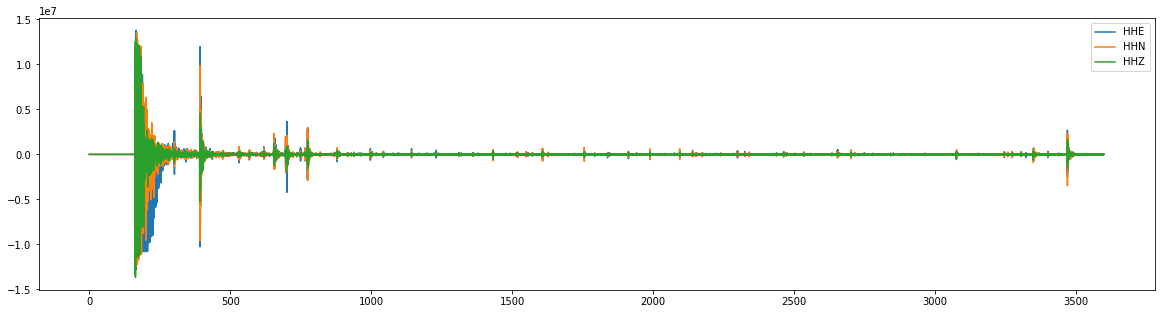

In [26]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

client = Client("INGV")

t = UTCDateTime(2009, 4, 6, 1, 30)
stream = client.get_waveforms(network="MN", station="AQU", location="*", channel="HH?", starttime=t, endtime=t+3600)


fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend();

#### Predict model on seismic stream

We can apply our varying models nowto the seismic stream through the high level ```annotate``` method. This will output the charactersitic functions for the probability of a P-phase, S-phase, and noise class respectively.

In [27]:
pn_preds = pn_model.annotate(stream)
eqt_preds = eqt_model.annotate(stream)
gpd_preds = gpd_model.annotate(stream)

In [28]:
pn_preds

3 Trace(s) in Stream:
MN.AQU..PhaseNet_P | 2009-04-06T01:29:59.998597Z - 2009-04-06T02:29:59.998597Z | 100.0 Hz, 360001 samples
MN.AQU..PhaseNet_S | 2009-04-06T01:29:59.998597Z - 2009-04-06T02:29:59.998597Z | 100.0 Hz, 360001 samples
MN.AQU..PhaseNet_N | 2009-04-06T01:29:59.998597Z - 2009-04-06T02:29:59.998597Z | 100.0 Hz, 360001 samples

#### Step through to 'zoom in' on predictions

Enter window length in seconds, and define which model predictions you would like to plot

In [54]:
wlength = 5 * 60 #@param
preds =  eqt_preds #@param

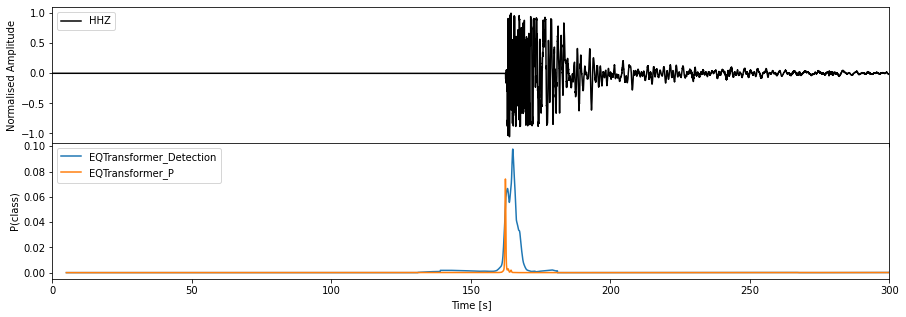

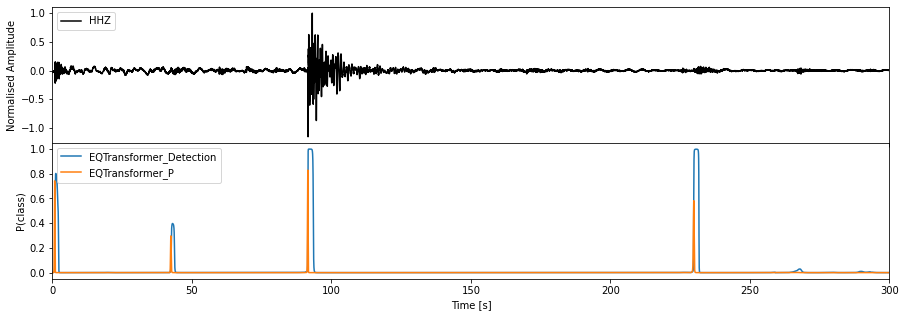

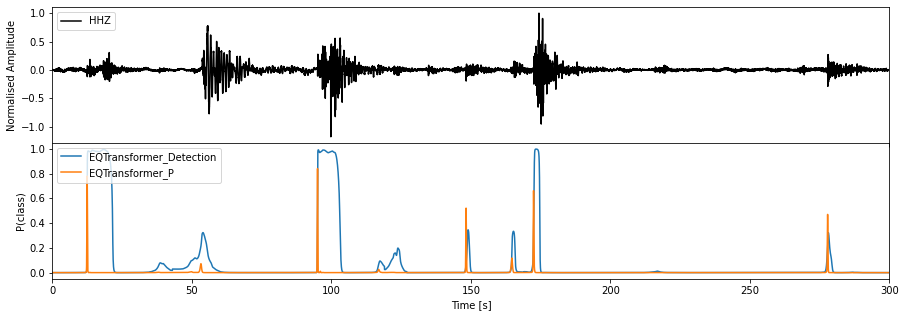

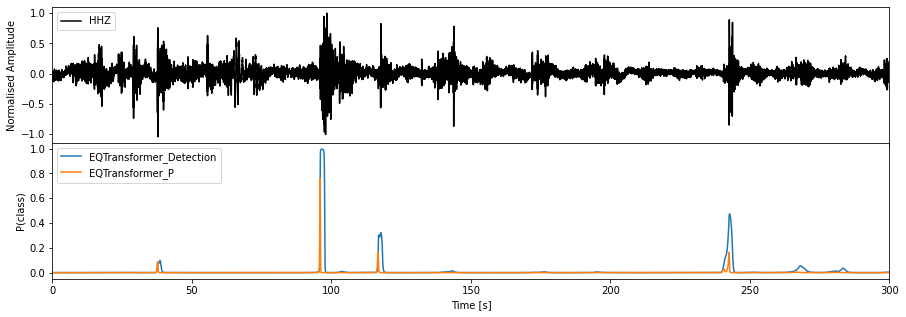

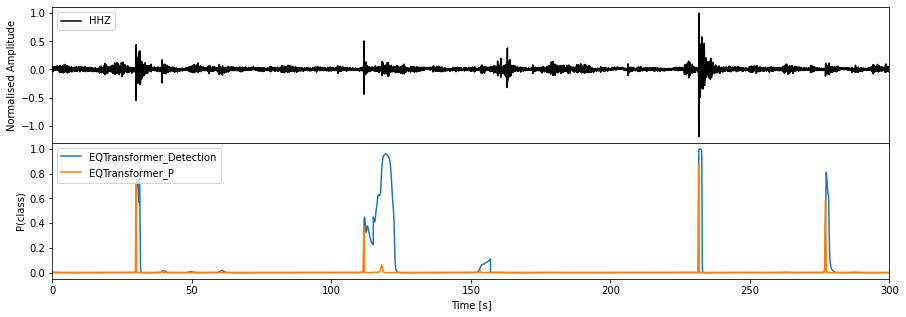

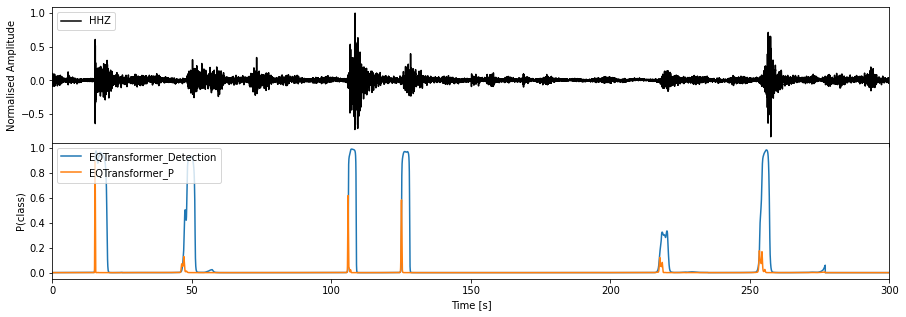

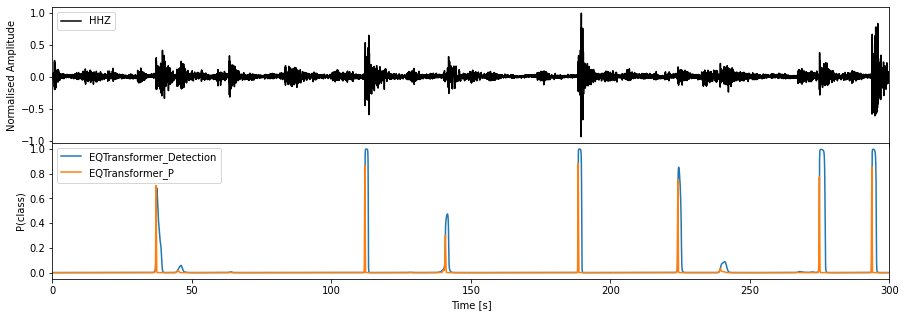

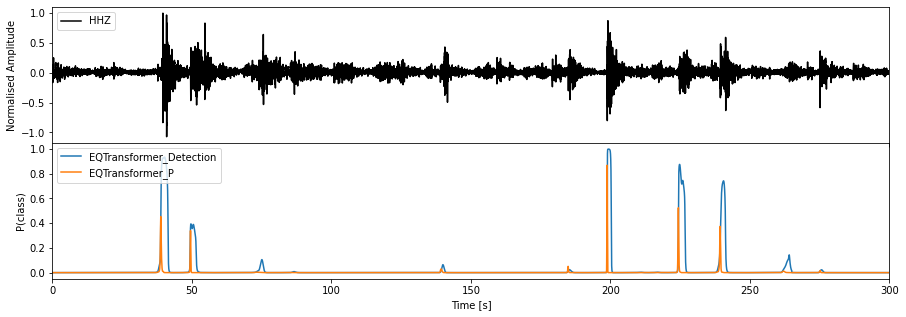

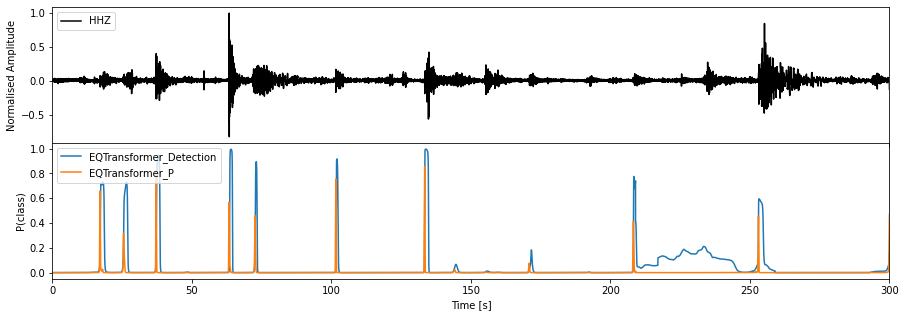

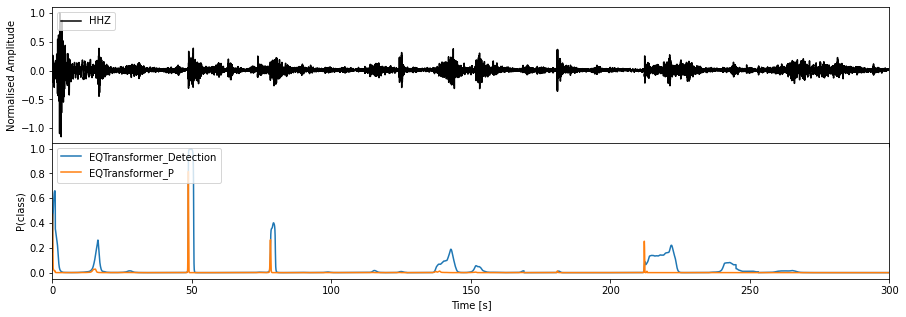

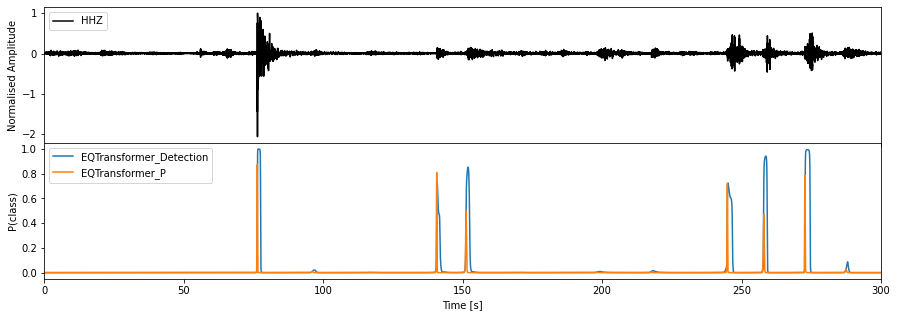

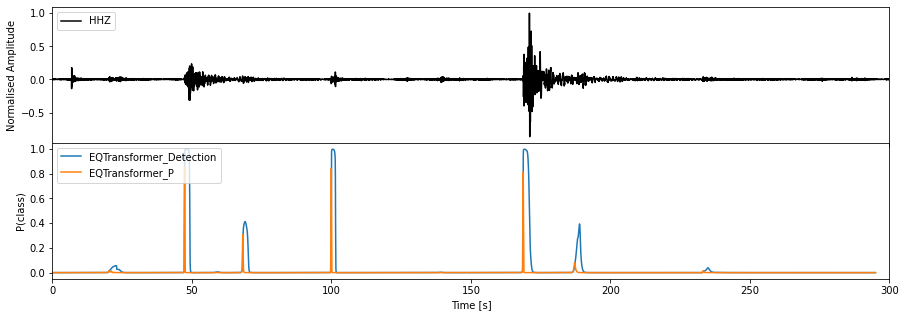

In [55]:

for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.slice(t0, t1)
    subpreds = preds.slice(t0, t1)

    offset = subpreds[0].stats.starttime - subst[0].stats.starttime

    fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True, gridspec_kw={'hspace' : 0})
    
    for i in range(2):
        ax[1].plot(offset + subpreds[i].times(), subpreds[i].data, label=subpreds[i].stats.channel)
    
    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].legend(loc=2)

    ax[1].set_ylabel('P(class)')
    ax[0].set_ylabel('Normalised Amplitude')
    ax[1].set_xlabel('Time [s]')
    plt.legend(loc=2)
    
    plt.show()

If you would like to then make deterministic detections from the continuous characteristic functions, the ```classify``` method of each model will allow you to perform this task.

In [59]:
detections = gpd_model.classify(stream)

In [61]:
print(f"Number of picks made by GPD: {len(detections)}")

Number of picks made by GPD: 1015


With each pick storing the following information:

In [58]:
detections[0].__dict__

{'end_time': 2009-04-06T01:30:10.298597Z,
 'peak_time': 2009-04-06T01:30:10.298597Z,
 'peak_value': 0.75503671,
 'phase': 'P',
 'start_time': 2009-04-06T01:30:10.298597Z,
 'trace_id': 'MN.AQU.'}